In [38]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from collections import defaultdict
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter

In [39]:
class Vehicle:
    _id_counter = 0
    """Define vehicle attributes and rules to be implemented"""
    def __init__(self, x_position, speed, max_speed, length, width, road_designation, vehicle_type, current_row, lane_changing_prob):
        self.vehicle_id = Vehicle._id_counter  # Assign a unique ID to each vehicle
        Vehicle._id_counter += 1  # Increment the counter for the next vehicle
        self.x_position = x_position #position along the length of the road (x position)
        self.speed = speed #number of cells the vehicle will move per timestep
        self.max_speed = max_speed #maximum speed
        self.braking_prob = 0.01 #probability of random slowdown
        self.length = length #length of the vehicle is the number of cells the vehicle occupies along the length of the road
        self.width = width #width of the vehicle is the number of cells the vehicle occupies along the width of the road
        self.road_designation = road_designation #whether inside or outside
        self.vehicle_type = vehicle_type #type of vehicle is determined by the size and behavior
        self.current_row = current_row #also known as the y position of the right side of the vehicle
        self.lane_changing_prob = lane_changing_prob #probability that a vehicle will transfer lane
        
    def accelerate(self):
        """Increases vehicle's speed by 1 cell, up to the maximum speed"""
        if self.speed < self.max_speed:
            self.speed += 1

    def lane_changing(self):
        """attempts to change lanes based on vehicle type and lane availability
        Here, we define a lane as a space of 2 cells wide. We assume a two-lane road(4 cells wide, with 1 cell wide passenger holding area beside row 0).
        We assume that each half lane is an array, imagine a vertical stack of arrays, indexing is from top to bottom (0-4). Right side is the bottom."""
        new_row = self.current_row + (2 if self.current_row == 0 else -2)
        # Check for space on the new lane
        if self.road_designation.road_occupancy[self.x_position:self.x_position + self.length, new_row:new_row + self.width].sum() == 0:
            self.current_row = new_row

    def decelerate(self, gap_distance):
        """decreases vehicle's speed to match the gap distance, given the speed>gap distance"""
        if self.speed > gap_distance:
            self.speed = gap_distance

    def braking(self):
        """Mimics random slowdown, randomly decreases vehicle's speed based on braking probability """
        if np.random.rand() < self.braking_prob and self.speed > 0:
            self.speed -= 1

    def move(self):
        """implements movement"""
        new_position = (self.x_position + self.speed) % self.road_designation.road_length
        self.x_position = new_position


    def __vehiclerepr__(self):
        """String representation of the vehicle - for debugging"""
        return f"Vehicle(ID={self.vehicle_id}, type={self.vehicle_type}, position={self.x_position}, speed={self.speed}, occupied_seats={self.occupied_seats})"

In [40]:
class Road:
    def __init__(self, road_length, road_width, speed_limit):
        self.road_length = road_length
        self.road_width = road_width
        self.speed_limit = speed_limit
        self.road_occupancy = np.zeros((road_length, road_width))

In [44]:
class IntraRoadSimulator:
    def __init__(self, road):
        self.road = road  # Store the road instance
        self.vehicles = []  # List to store vehicle instances
        self.passengers = []  # List to store passenger instances
        self.occupancy_history = []  # List to store the history of road occupancy states
        self.vehicle_throughput = 0
        self.slowdown_counts = 0  # Counter for the number of slowdowns due to traffic

    def update_occupancy(self):
        self.road.road_occupancy.fill(0)
        for vehicle in self.vehicles:
            x_start = vehicle.x_position
            x_end = (vehicle.x_position + vehicle.length) % self.road.road_length
            y_start = vehicle.current_row
            y_end = min(vehicle.current_row + vehicle.width, self.road.road_width)
            if x_start < x_end:
                self.road.road_occupancy[x_start:x_end, y_start:y_end] = 1
            else:
                self.road.road_occupancy[x_start:, y_start:y_end] = 1
                self.road.road_occupancy[:x_end, y_start:y_end] = 1
        self.occupancy_history.append(self.road.road_occupancy.copy())

    def initialize_vehicles(self, density, truck_fraction, truck_lane_change_prob, jeep_lane_change_prob):
        A, B = 7 * 2, 3 * 2  # Constants for truck and jeep area
        L, W = self.road.road_length, self.road.road_width  # Road dimensions
        N = int(density * L * W * (truck_fraction / A + (1 - truck_fraction) / B))  # Number of vehicles based on density and truck fraction
        for _ in range(N):
            vehicle_type = 'truck' if np.random.rand() < truck_fraction else 'jeep'  # Randomly decide vehicle type
            length = 7 if vehicle_type == 'truck' else 3
            width = 2
            x_position = np.random.randint(0, self.road.road_length)  # Random initial position
            speed = np.random.randint(1, self.road.speed_limit + 1)
            lane_changing_prob = truck_lane_change_prob if vehicle_type == 'truck' else jeep_lane_change_prob
            current_row = 2 if vehicle_type == 'truck' else 0
            if self.road.road_occupancy[x_position:x_position + length, current_row:current_row + width].sum() == 0:
                new_vehicle = Vehicle(x_position, speed, self.road.speed_limit, length, width, self.road, vehicle_type, current_row, lane_changing_prob)
                self.vehicles.append(new_vehicle)  # Add vehicle to the list
                self.road.road_occupancy[x_position:x_position + length, current_row:current_row + width] = 1  # Mark vehicle position on road occupancy grid

    def gap_distance(self, vehicle, vehicle_lane_to_be_checked): 
        """Debugging this - make gap distance consider toroidal boundary cond. recently introduced"""
        current_x_position = vehicle.x_position
        max_distance = min(vehicle.speed, self.road.road_length - current_x_position - vehicle.length) #This ensures that the gap distance does not wrap around (need to change one way or another)
        gap_distance_row_1 = max_distance
        gap_distance_row_2 = max_distance
        for distance in range(1, max_distance + 1):
            next_x_position = current_x_position + vehicle.length + distance - 1
            if next_x_position >=self.road.road_length or self.road.road_occupancy[next_x_position, vehicle_lane_to_be_checked] == 1:
                gap_distance_row_1 = distance  # Calculate gap distance in current lane
                break
        for distance in range(1, max_distance + 1):
            next_x_position = current_x_position + vehicle.length + distance - 1
            if next_x_position>= self.road.road_length or self.road.road_occupancy[next_x_position, vehicle_lane_to_be_checked + 1] == 1:
                gap_distance_row_2 = distance  # Calculate gap distance in adjacent lane
                break
        return min(gap_distance_row_1, gap_distance_row_2)  # Return the minimum gap distance
                        
    def record_throughput(self, vehicle):
        self.vehicle_throughput += 1

    def simulation_step(self, density, truck_fraction):
        for vehicle in self.vehicles:
            gap_distance_of_own_lane = self.gap_distance(vehicle, vehicle.current_row)  # Calculate gap distance in current lane
            vehicle.accelerate()  # Accelerate the vehicle
            
            if vehicle.speed > gap_distance_of_own_lane:
                other_lane = 2 if vehicle.current_row == 0 else 0  # Determine other lane
                gap_distance_of_other_lane = self.gap_distance(vehicle, other_lane)  # Calculate gap distance in other lane
                if gap_distance_of_other_lane > gap_distance_of_own_lane:
                    if np.random.rand() < vehicle.lane_changing_prob:
                        #print(f"Vehicle {vehicle.vehicle_id} changing lanes")
                        vehicle.lane_changing()  # Change lane if possible
                        vehicle.decelerate(gap_distance_of_own_lane)
                        # Decelerate if necessary
                    else:
                        #print(f"Vehicle {vehicle.vehicle_id} decelerating in own lane")
                        vehicle.decelerate(gap_distance_of_own_lane)  # Decelerate if not changing lanes
                          # Apply brakes
                        self.slowdown_counts += 1  # Increment slowdown count
            vehicle.braking()    
            if vehicle.x_position == self.road.road_length - vehicle.length: #Greatest fix: redundant +speed and -length on position and road length sides, respectively
                #print(f"Vehicle {vehicle.vehicle_id} reached end of road at position {vehicle.x_position}")
                self.record_throughput(vehicle)
                
            vehicle.move()  # Move the vehicle
            
        self.update_occupancy()  # Update the road occupancy grid

    def visualize(self, step_count):
        plt.figure(figsize=(20, 6))
        plt.imshow(self.road.road_occupancy.T, cmap='gray_r', origin='lower')
        plt.title(f'Step {step_count}')
        plt.xlabel('Road Length')
        plt.ylabel('Lane')
        plt.xticks(range(0, self.road.road_length + 1, 1))
        plt.yticks(range(0, self.road.road_width + 1, 1))
        plt.tight_layout()
        plt.show()

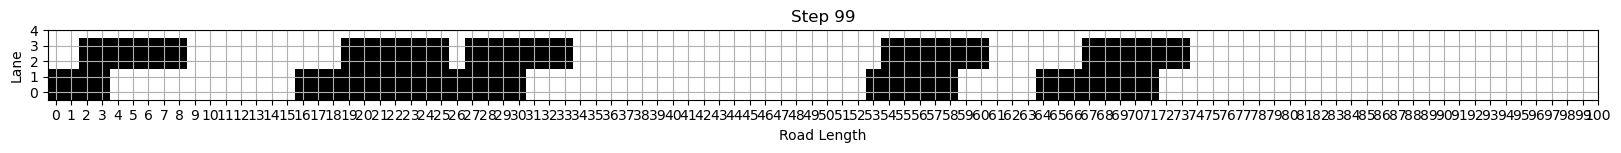

In [45]:
def animate(step):
    simulator.simulation_step(density, truck_fraction)  # Run a simulation step
    ax.clear()  # Clear the previous plot
    ax.imshow(simulator.road.road_occupancy.T, cmap='gray_r', origin='lower')
    ax.set_title(f'Step {step}')
    ax.set_xlabel('Road Length')
    ax.set_ylabel('Lane')
    ax.set_xticks(range(0, simulator.road.road_length + 1, 1))
    ax.set_yticks(range(0, simulator.road.road_width + 1, 1))
    ax.grid(True)

# Initialize road and simulator
road = Road(road_length=100, road_width=4, speed_limit=5)
simulator = IntraRoadSimulator(road)

density = 1
truck_fraction = 0.1

simulator.initialize_vehicles(density, truck_fraction, 0.8, 0)  # Initialize vehicles

# Set up the figure and axis for animation
fig, ax = plt.subplots(figsize=(20, 6))

# Create the animation
anim = FuncAnimation(fig, animate, frames=100, interval=200)

# Save the animation as a GIF or MP4
anim.save('road_simulation_vehicle_only.gif', writer='pillow')
# Or save as MP4
# anim.save('road_simulation.mp4', writer='ffmpeg')

# Show the animation in a Jupyter notebook (if using one)
plt.show()